# Shock finding in a moving mesh - RICH radiation hydrodynamics
[Schaal & Springel, 2015](https://arxiv.org/abs/1407.4117), [Schaal et al, 2016](https://arxiv.org/abs/1604.07401)

## Step 1: flag the shock zones
According to these three criteria
$$
\begin{gather}
\partial_i v^i < 0
\\
\partial^i T \partial_i p > 0
\\
\Delta \log T \geq \log \left. \frac{T_2}{T_1} \right|_{\mathcal{M}_\mathrm{min}}
\\
\Delta \log p \geq \log \left. \frac{p_2}{p_1} \right|_{\mathcal{M}_\mathrm{min}}
\end{gather}
$$

In [1]:
%load_ext autoreload
%autoreload 2
import os

import numpy as np
import h5py
import matplotlib.pyplot as plt
import unyt as u
import math

import richio
import nb, dev

In [2]:
snap_dir = '/home/hey4/rich_tde/data/raw/SedovDissipationGrad'
!ls $snap_dir

sedov_0.h5   sedov_100.h5   sedov_50.h5   sedov_final.h5
sedov_0.vtu  sedov_100.vtu  sedov_50.vtu  sedov_final.vtu


In [3]:
snap = richio.load(os.path.join(snap_dir, 'sedov_100.h5'))

In [4]:
snap.info()

                                     RICH SNAPSHOT INFORMATION                                      

Snapshot Details                        
----------------------------------------------------------------------------------------------------
  Path                      : /home/hey4/rich_tde/data/raw/SedovDissipationGrad/sedov_100.h5
  Snapshot Number           : -1
  Time                      : [0.0042907] code_time
  Box size                  : [-1. -1. -1.  1.  1.  1.] code_length
  Cycle                     : [100.] dimensionless
  Number of Ranks           : 1

Available Fields                         [Unit System: RICH]
----------------------------------------------------------------------------------------------------
Field           Unit                                     Aliases
----------------------------------------------------------------------------------------------------
Box             code_length                              box_size, box, boxsize
CMx             co

/zfsstore/user/hey4/rich_tde/richio/richio/units.py:117: UserWarning: 'Eg_0' is in the data output but not used in the simulation.
  warnings.warn(f"'{key}' is in the data output but not used in the simulation.")


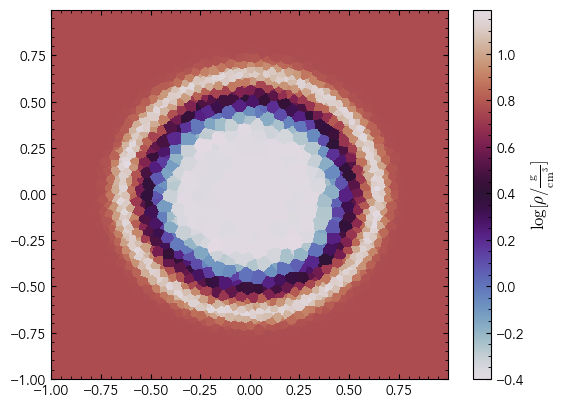

In [5]:
ax, im, data = snap.plots.peek()
plt.show()

In [6]:
def shock_direction(grad_T):
    """Find the shock direction given temperature gradient.
    d_s = - grad_T / |grad_T|
    """
    norm_grad_T = np.linalg.norm(grad_T, axis=1, keepdims=True)

    # For small magnitudes, set ds to zero
    ds = - grad_T / norm_grad_T

    ds[norm_grad_T < 1e-3] = 0 # TODO: accommodate for units
    # ds = np.where(norm_grad_T < 1e-3, np.zeros_like(grad_T), - grad_T / norm_grad_T)

    return ds

### The first condition

In [7]:
# First condition
condition1 = snap.divV < 0

In [8]:
rho = snap.density
rho_shocked = np.where(condition1, rho, 0*rho)

/home/hey4/.conda/envs/richanalysis/lib/python3.13/site-packages/unyt/array.py:1832: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


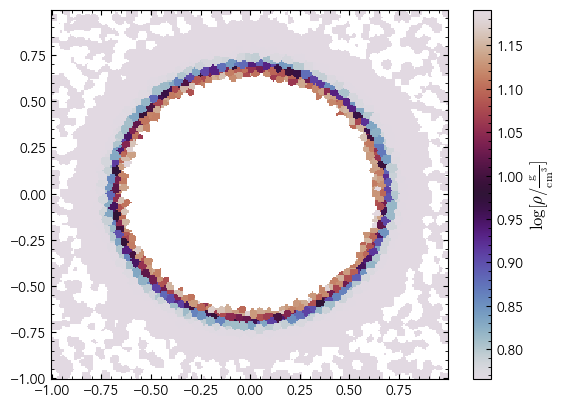

In [9]:
ax, im, sliced_rho = snap.plots.slice(rho_shocked, res=256)
plt.show()

### The second condition
$$
\begin{gather}
T = \frac{\mu m_H}{k_B} \frac{P}{\rho},\\
\partial^i T = \frac{\mu m_H}{k_B} [(\partial^iP)/\rho - P (\partial^i \rho) /\rho^2].
\end{gather}
$$

In [10]:
grad_P = np.stack([snap.DpDx, snap.DpDy, snap.DpDz], axis=-1)
grad_rho = np.stack([snap.DrhoDx, snap.DrhoDy, snap.DrhoDz], axis=-1)
P = snap.P
rho = snap.rho

In [11]:
# numpy only broadcasts if we have matching trailing index (e.g., shape (3,10,)
# + shape (10,) works, but (10,3,) + shape (10,), which is what we have here,
# doesn't). So we transpose to (3,10,) to make it work and transpose back to 
# (10,3,) in the end.
grad_T = u.mh / u.kb * (grad_P.T / rho - P * grad_rho.T / rho**2).T

In [13]:
# The second condition
condition2 = np.vecdot(grad_T, grad_P) > 0
np.shape(condition2)

(100000,)

In [ ]:
np.sum(condition2) # most of it is true

np.int64(92404)

In [15]:
rho_shocked = np.where(condition1 & condition2, rho, 0*rho)

/home/hey4/.conda/envs/richanalysis/lib/python3.13/site-packages/unyt/array.py:1832: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


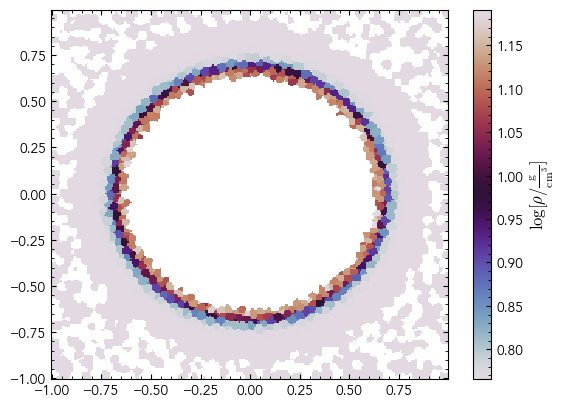

In [16]:
ax, im, sliced_rho = snap.plots.slice(rho_shocked, res=256)
plt.show()

### The third condition
How to evaluate $\Delta \log T$?

In [ ]:
def searching_tree(tree, point):
    _, idx = tree.query(point)
    return idx

def find_prepost(sim_tree, X, Y, Z, point, ds, delta, direction):
    """Find the previous/next point along the shock direction by moving in
    the shock direction by steps of distance `delta` each time.
    """

    if direction == 'post':
        delta = - delta
        
    k = 0
    # check that you are not taking the same point as the one given
    distance = 0

    while distance == 0:
        k += 1
        new_point = point + k * delta * ds 
        idx  = searching_tree(sim_tree, new_point) # sim_tree.query(new_point)
        new_point = np.array([X[idx], Y[idx], Z[idx]])
        distance = math.dist(point, new_point)

    final_step = k*np.abs(delta)

    return idx, final_step


## Step 2: shock surface
This involves a "ray tracing" step

In [ ]:
def find_T_mach(T2_T1, gamma):
    """ Find mach number from the temperature jump (T2_T1). """
    a = 2*gamma*(gamma-1)
    minusb = gamma*2-6*gamma + T2_T1*(gamma+1)**2 + 1
    M2 = (minusb + np.sqrt(minusb**2 + 8*a*(gamma-1))) / (2*a)
    return np.sqrt(M2)

def find_P_mach(P2_P1, gamma):
    """ Find mach number from the pressure jump (P2_P1). """
    M2 = (P2_P1*(gamma+1)+gamma-1) / (2*gamma)
    return np.sqrt(M2)

def find_rho_mach(rho2_rho1, gamma):
    """ Find mach number from the density jump (rho2_rho1). """
    M2 = 2*rho2_rho1 / (gamma+1-rho2_rho1*(gamma-1))
    return np.sqrt(M2)